In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/u/ajagadish/vanilla-llama/categorisation/')
sys.path.append('/u/ajagadish/vanilla-llama/categorisation/data')
sys.path.append('/u/ajagadish/vanilla-llama/categorisation/rl2')
import torch
# from rl2.model import RL2, MetaLearner
# from evaluate import evaluate_1d, evaluate_metalearner
import torch.nn.utils.rnn as rnn_utils
import numpy as np
FONTSIZE=20
import pandas as pd
import seaborn as sns

In [3]:
import json
with open('../data/human/johanssen2002.json') as f:
    human_data = json.load(f)
# human data procesing
human_data_dict = {}
for i, stimulus_id in enumerate(human_data['x']):
    human_data_dict[stimulus_id] = human_data['y'][i]
human_data_df = pd.DataFrame.from_dict(human_data_dict, orient='index', columns=['human_choice'])
human_data_df['stimulus_id'] = human_data_df.index
human_data_df = human_data_df[human_data_df['stimulus_id'].str.contains('T')]
human_generalisation = human_data_df['human_choice'].sort_values()

num_runs = 1
min_distance = np.inf
for beta in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    data = pd.read_csv(f'../data/meta_learner/johanssen_categorisation__tasks8950_pversion5_stage1_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=1_beta={beta}_num_trials=288_num_runs={num_runs}.csv')
    transfer_stimulus_ids = data[data['stimulus_id'].str.contains('T')]['stimulus_id']
    transfer_data = data[data['stimulus_id'].isin(transfer_stimulus_ids)]
    # subselect stimulus_id whose values have letter 'T' in them 
    transfer_stimulus_ids = data[data['stimulus_id'].str.contains('T')]['stimulus_id']
    transfer_data = data[data['stimulus_id'].isin(transfer_stimulus_ids)]
    over_blocks = [32] #transfer_data.task_feature.unique()
    for task_block in over_blocks:

        # choose a subset of the transfer_data dataframe where the task_feature is equal to 1
        transfer_data = transfer_data[transfer_data['task_feature'] == task_block]
        if transfer_data.shape[0] == 0:
            continue
        # get the mean choice for each stimulus_id and sort the values in the order of the magnitude of the mean for both the transfer_data and human_data_df
        meta_learner_generalisation = (1-transfer_data.groupby('stimulus_id')['choice'].mean())
        meta_learner_generalisation = meta_learner_generalisation[human_generalisation.index]

        # compute distance between human_generalisation and meta_learner_generalisation
        distance = np.linalg.norm(human_generalisation.values - meta_learner_generalisation.values)
        if distance < min_distance:
            min_distance = distance
            best_beta = beta
            best_human_generalisation = human_generalisation
            best_meta_learner_generalisation = meta_learner_generalisation
            best_task_block = task_block   

print(f'best_beta={best_beta}, best_task_block={best_task_block}, min_distance={min_distance}')

best_beta=0.9, best_task_block=32, min_distance=0.2932301711887589


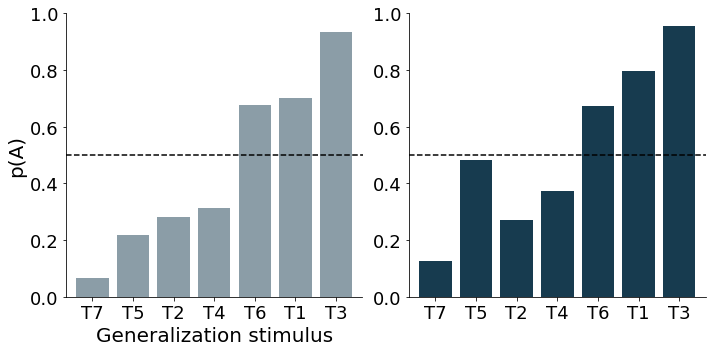

In [16]:
# choose  params for ermi simulations
beta = 0.9
#num_runs = 1
# chose task block from ERMI to compare with human data
task_block = 32

data = pd.read_csv(f'../data/meta_learner/johanssen_categorisation__tasks8950_pversion5_stage1_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=1_beta={beta}_num_trials=288_num_runs={num_runs}.csv')
transfer_stimulus_ids = data[data['stimulus_id'].str.contains('T')]['stimulus_id']
transfer_data = data[data['stimulus_id'].isin(transfer_stimulus_ids)]
# choose a subset of the transfer_data dataframe where the task_feature is equal to 1
transfer_data = transfer_data[transfer_data['task_feature'] == task_block]
import json
with open('../data/human/johanssen2002.json') as f:
    human_data = json.load(f)

# human data procesing
human_data_dict = {}
for i, stimulus_id in enumerate(human_data['x']):
    human_data_dict[stimulus_id] = human_data['y'][i]
human_data_df = pd.DataFrame.from_dict(human_data_dict, orient='index', columns=['human_choice'])
human_data_df['stimulus_id'] = human_data_df.index
human_data_df = human_data_df[human_data_df['stimulus_id'].str.contains('T')]

# get the mean choice for each stimulus_id and sort the values in the order of the magnitude of the mean for both the transfer_data and human_data_df
human_generalisation = human_data_df['human_choice'].sort_values()
meta_learner_generalisation = (1-transfer_data.groupby('stimulus_id')['choice'].mean())
# keep the same order of the stimulus_ids for both human_generalisation and meta_learner_generalisation
meta_learner_generalisation = meta_learner_generalisation[human_generalisation.index]

# compare the meta_learner_generalisation with human_generalisation in two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot the human_generalisation in the left subplot
human_generalisation.plot(kind='bar', ax=ax[0], color='#8b9da7', width=0.8)
# plot the meta_learner_generalisation in the right subplot
meta_learner_generalisation.plot(kind='bar', ax=ax[1], color='#173b4f', width=0.8)
# set the x-ticks for both subplots
ax[0].set_xticks(np.arange(human_generalisation.shape[0]))
ax[1].set_xticks(np.arange(meta_learner_generalisation.shape[0]))
# set the x-tick labels for both subplots
ax[0].set_xticklabels(human_generalisation.index, rotation=0)
ax[1].set_xticklabels(meta_learner_generalisation.index, rotation=0)
# set the y-ticks for both subplotsand only keep alternating y-tick labels
y_ticks = np.round(np.arange(0, 1.1, 0.1)[::2],1)
ax[0].set_yticks(y_ticks)
ax[1].set_yticks(y_ticks)
ax[0].set_yticklabels(y_ticks, fontsize=FONTSIZE-2)
ax[1].set_yticklabels(y_ticks, fontsize=FONTSIZE-2)
# set the x-label for both subplots
ax[0].set_xlabel('Generalization stimulus', fontsize=FONTSIZE)
# ax[1].set_xlabel('Generalization stimulus', fontsize=FONTSIZE)
# set the y-label for both subplots
ax[0].set_ylabel('p(A)', fontsize=FONTSIZE)
# set the title for both subplots
# ax[0].set_title('Human', fontsize=FONTSIZE)
# ax[1].set_title('ERMI', fontsize=FONTSIZE)
# set the fontsize for both subplots
ax[0].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
ax[1].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
# set the ylim for both subplots
ax[0].set_ylim([0, 1.0])
ax[1].set_ylim([0, 1.0])
# draw a horizontal line at y=0.5
ax[0].axhline(y=0.5, linestyle='--', color='black')
ax[1].axhline(y=0.5, linestyle='--', color='black')
fig.tight_layout()
sns.despine()
plt.show()

fig.savefig(f'../figures/ermi_vs_human_generalisation_beta={beta}_task_block={task_block}.svg', bbox_inches='tight', dpi=300)


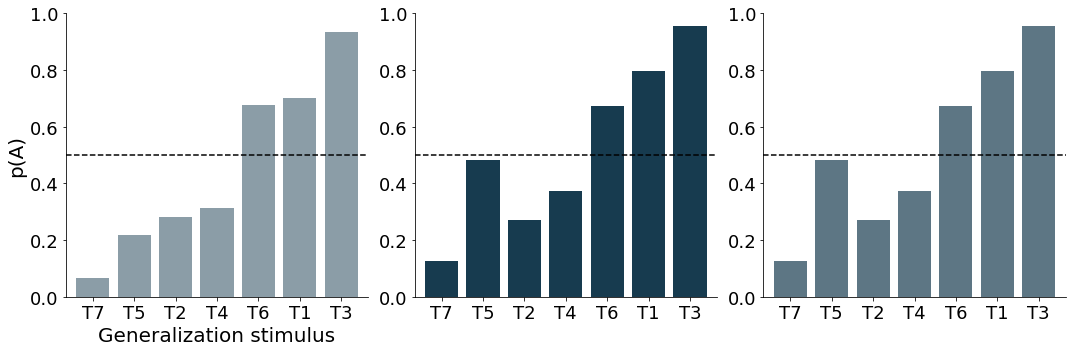

In [22]:
# choose  params for ermi simulations
ermi_beta = 0.9
mi_beta = 0.9
num_runs = 1
task_block = 32 # chose task block from ERMI to compare with human data

data = pd.read_csv(f'../data/meta_learner/johanssen_categorisation__tasks8950_pversion5_stage1_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=1_beta={beta}_num_trials=288_num_runs={num_runs}.csv')
transfer_stimulus_ids = data[data['stimulus_id'].str.contains('T')]['stimulus_id']
transfer_data = data[data['stimulus_id'].isin(transfer_stimulus_ids)]
# choose a subset of the transfer_data dataframe where the task_feature is equal to 1
transfer_data = transfer_data[transfer_data['task_feature'] == task_block]

mi_data = pd.read_csv(f'../data/meta_learner/johanssen_categorisation__tasks8950_pversion5_stage1_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=1_beta={beta}_num_trials=288_num_runs={num_runs}.csv')
mi_transfer_stimulus_ids = mi_data[mi_data['stimulus_id'].str.contains('T')]['stimulus_id']
mi_transfer_data = mi_data[mi_data['stimulus_id'].isin(mi_transfer_stimulus_ids)]
# choose a subset of the transfer_data dataframe where the task_feature is equal to 1
mi_transfer_data = mi_transfer_data[mi_transfer_data['task_feature'] == task_block]

import json
with open('../data/human/johanssen2002.json') as f:
    human_data = json.load(f)

# human data procesing
human_data_dict = {}
for i, stimulus_id in enumerate(human_data['x']):
    human_data_dict[stimulus_id] = human_data['y'][i]
human_data_df = pd.DataFrame.from_dict(human_data_dict, orient='index', columns=['human_choice'])
human_data_df['stimulus_id'] = human_data_df.index
human_data_df = human_data_df[human_data_df['stimulus_id'].str.contains('T')]

# get the mean choice for each stimulus_id and sort the values in the order of the magnitude of the mean for both the transfer_data and human_data_df
human_generalisation = human_data_df['human_choice'].sort_values()
ermi_meta_learner_generalisation = (1-transfer_data.groupby('stimulus_id')['choice'].mean())
ermi_meta_learner_generalisation = meta_learner_generalisation[human_generalisation.index]
mi_meta_learner_generalisation = (1-mi_transfer_data.groupby('stimulus_id')['choice'].mean())
mi_meta_learner_generalisation = mi_meta_learner_generalisation[human_generalisation.index] # keep the same order of the stimulus_ids for both human_generalisation and meta_learner_generalisation

# compare the meta_learner_generalisation with human_generalisation in two subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(5*3, 5))
# plot the human_generalisation in the left subplot
human_generalisation.plot(kind='bar', ax=ax[0], color='#8b9da7', width=0.8)
# plot the meta_learner_generalisation in the right subplot
meta_learner_generalisation.plot(kind='bar', ax=ax[1], color='#173b4f', width=0.8)
mi_meta_learner_generalisation.plot(kind='bar', ax=ax[2], color='#5d7684', width=0.8)

# set the x-ticks for both subplots
ax[0].set_xticks(np.arange(human_generalisation.shape[0]))
ax[1].set_xticks(np.arange(meta_learner_generalisation.shape[0]))
ax[2].set_xticks(np.arange(mi_meta_learner_generalisation.shape[0]))
# set the x-tick labels for both subplots
ax[0].set_xticklabels(human_generalisation.index, rotation=0)
ax[1].set_xticklabels(meta_learner_generalisation.index, rotation=0)
ax[2].set_xticklabels(mi_meta_learner_generalisation.index, rotation=0)
# set the y-ticks for both subplotsand only keep alternating y-tick labels
y_ticks = np.round(np.arange(0, 1.1, 0.1)[::2],1)
ax[0].set_yticks(y_ticks)
ax[1].set_yticks(y_ticks)
ax[2].set_yticks(y_ticks)
ax[0].set_yticklabels(y_ticks, fontsize=FONTSIZE-2)
ax[1].set_yticklabels(y_ticks, fontsize=FONTSIZE-2)
ax[2].set_yticklabels(y_ticks, fontsize=FONTSIZE-2)
# set the x-label for both subplots
ax[0].set_xlabel('Generalization stimulus', fontsize=FONTSIZE)
# ax[1].set_xlabel('Generalization stimulus', fontsize=FONTSIZE)
# set the y-label for both subplots
ax[0].set_ylabel('p(A)', fontsize=FONTSIZE)
# set the title for both subplots
# ax[0].set_title('Human', fontsize=FONTSIZE)
# ax[1].set_title('ERMI', fontsize=FONTSIZE)
# set the fontsize for both subplots
ax[0].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
ax[1].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
ax[2].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
# set the ylim for both subplots
ax[0].set_ylim([0, 1.0])
ax[1].set_ylim([0, 1.0])
ax[2].set_ylim([0, 1.0])
# draw a horizontal line at y=0.5
ax[0].axhline(y=0.5, linestyle='--', color='black')
ax[1].axhline(y=0.5, linestyle='--', color='black')
ax[2].axhline(y=0.5, linestyle='--', color='black')
fig.tight_layout()
sns.despine()
plt.show()

fig.savefig(f'../figures/ermi_vs_human_generalisation_beta={beta}_task_block={task_block}.svg', bbox_inches='tight', dpi=300)
